In [8]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import json
import re

In [9]:
# Strip newline carriage return and leading/trailing whitespace
def custom_strip(text):
    if isinstance(text, str):
        return text.strip("\n\r").strip()
    return text

In [10]:
data_file = Path("data/Tripfile_Beispieldaten.csv")
data = pd.read_csv(data_file, sep=";", index_col="id")

In [11]:
# Clean up data
data = data.map(custom_strip)
data["creation_time"] = pd.to_datetime(data["creation_time"])
data.to_csv("data/Tripfile_Beispieldaten_cleaned.csv", sep=";", index_label="id")

data.to_json("data/Tripfile_Beispieldaten_cleaned.json", orient="index", index=True)

In [12]:
list(data.columns)

['creation_time',
 'airline_code',
 'flight_number',
 'flight_suffix',
 'flight_date',
 'departure_airport',
 'user_name',
 'action_name',
 'header_line',
 'entry_details']

In [13]:
unique_actions = data.action_name.unique()

In [14]:
counts = pd.Series(data.action_name.value_counts(), index=unique_actions)

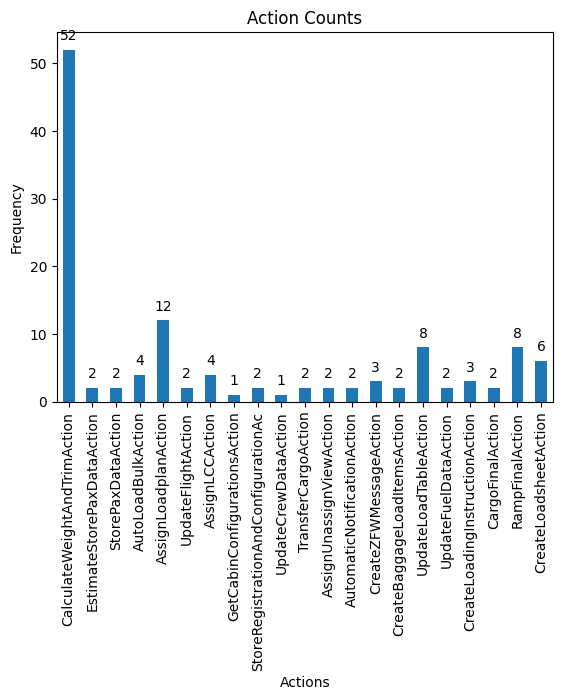

In [15]:
ax = counts.plot(kind="bar")
plt.title("Action Counts")
plt.xlabel("Actions")
plt.ylabel("Frequency")

for p in ax.patches:  # Loop over each bar
    ax.annotate(
        f"{p.get_height()}",  # Text to display
        (p.get_x() + p.get_width() / 2.0, p.get_height()),  # Position
        ha="center",  # Center horizontally
        va="bottom",  # Vertically align at the bottom
        xytext=(0, 5),  # Text offset
        textcoords="offset points",
    )

plt.show()

In [16]:
action_unique_messages = {}
action_uniques_count = pd.Series(index=unique_actions)
for action in data.action_name.unique():
    action_data = data[data.action_name == action]
    action_unique_messages[action] = list(action_data.entry_details.unique())
    action_uniques_count[action] = len(action_unique_messages[action])

In [17]:
json.dump(action_unique_messages, open("data/action_unique_messages.json", "w"))

In [18]:
def write_to_file(text: str, fileneame: str):
    with open(fileneame, "w") as file:
        file.write(text)

In [19]:
text = action_unique_messages["StorePaxDataAction"][1]
write_to_file(text, "message.txt")

In [20]:
text

'START_WI weight               : 45102.00  KG               START_WI index                : 37.23                     \r\n DO_WI weight                  : 45516.00  KG               DO_WI index                   : 37.42                     \r\n PAX_WI weight                 : 7500.00   KG               PAX_WI index                  : 0.74                               \r\n TOTAL_DEADLOAD_WI weight      : 45516.00  KG               TOTAL_DEADLOAD_WI index       : 37.42                               \r\n TOTAL_LOAD_WI                 : 0.00      KG               TOTAL_TRAFFIC_LOAD            : 7500.00   KG              \r\n FUEL_INDEX                    : 0.00                      \r\n AZFW                          : 53016.00  KG               ATOW                          : 53016.00  KG                         \r\n ALAW                          : 53016.00  KG               ATXW                          : 53016.00  KG                                  \r\n AFT_LIMIT_ZFW                 : 

In [21]:
pattern = r"(\w+)\s*:\s*([0-9\.]+)\s*KG|\w+\s*:\s*([0-9\.]+)"

# Find all matches in the string
matches = re.findall(pattern, text)

# Initialize an empty dictionary to hold the parsed data
data_dict = {}

# Loop through the matches to populate the dictionary
for match in matches:
    key = match[0]  # The key
    value_position = (
        match[1] if match[1] else match[2]
    )  # The value, depending on which group is populated
    data_dict[key] = float(value_position)  # Convert the value to float and store it

In [22]:
matches

[('weight', '45102.00', ''),
 ('', '', '37.23'),
 ('weight', '45516.00', ''),
 ('', '', '37.42'),
 ('weight', '7500.00', ''),
 ('', '', '0.74'),
 ('weight', '45516.00', ''),
 ('', '', '37.42'),
 ('TOTAL_LOAD_WI', '0.00', ''),
 ('TOTAL_TRAFFIC_LOAD', '7500.00', ''),
 ('', '', '0.00'),
 ('AZFW', '53016.00', ''),
 ('ATOW', '53016.00', ''),
 ('ALAW', '53016.00', ''),
 ('ATXW', '53016.00', ''),
 ('', '', '53.14')]

In [160]:
def parse(
    text: str,
    pattern: str,
    meta: list[str],
):
    # Find all matches in the string
    matches = re.findall(pattern, text)
    data_dict = {}

    key_positions = []
    value_position = -1
    unit_position = -1
    # Extract the positions of the keys, value and unit
    # Raise an error if there is more than one value or unit
    for i, item in enumerate(meta):
        if item == "key":
            key_positions.append(i)
        if item == "value":
            if not value_position == -1:
                raise ValueError("Only one value allowed")
            value_position = i
        if item == "unit":
            if not unit_position == -1:
                raise ValueError("Only one unit allowed")
            unit_position = i
    for match in matches:
        # Construct the key name
        key = "_".join([match[i] for i in key_positions if match[i]])
        # The numeric value
        value = float(match[value_position])
        data_dict[key] = value
        # If there is a unit specified and the unit is not empty add th unit to the dictionary
        if not unit_position == -1:
            if match[unit_position]:
                data_dict[f"{key}_unit"] = match[unit_position]

    return data_dict

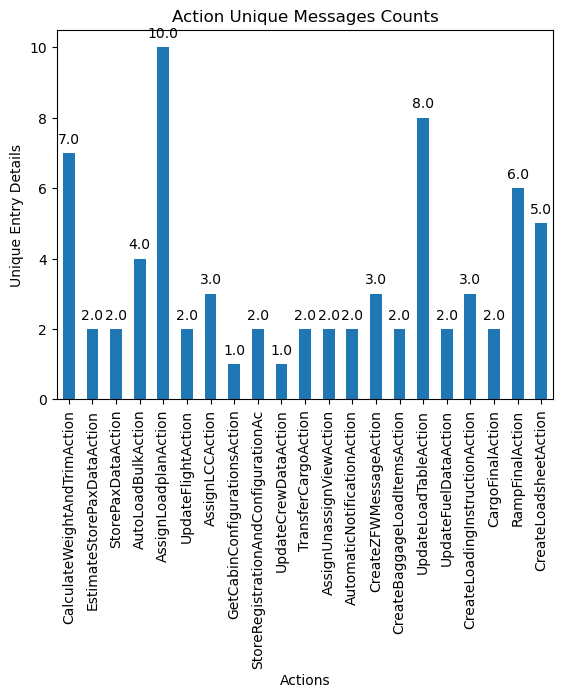

In [14]:
ax = action_uniques_count.plot(kind="bar")
plt.title("Action Unique Messages Counts")
plt.xlabel("Actions")
plt.ylabel("Unique Entry Details")

for p in ax.patches:  # Loop over each bar
    ax.annotate(
        f"{p.get_height()}",  # Text to display
        (p.get_x() + p.get_width() / 2.0, p.get_height()),  # Position
        ha="center",  # Center horizontally
        va="bottom",  # Vertically align at the bottom
        xytext=(0, 5),  # Text offset
        textcoords="offset points",
    )
plt.show()

In [15]:
x = {
    "START_WI_weight": 45102.00,
    "START_WI_weight_unit": "KG",
    "START_WI_index": 37.23,
    "DO_WI_weight": 45516.00,
    "DO_WI_weight_unit": "KG",
    "DO_WI_index": 37.42,
    "PAX_WI_weight": 7500.00,
    "PAX_WI_weight_unit": "KG",
    "PAX_WI_index": 0.74,
    "TOTAL_DEADLOAD_WI_weight": 45516.00,
    "TOTAL_DEADLOAD_WI_weight_unit": "KG",
    "TOTAL_DEADLOAD_WI_index": 37.42,
    "TOTAL_LOAD_WI": 0.00,
    "TOTAL_LOAD_WI_unit": "KG",
    "TOTAL_TRAFFIC_LOAD": 7500.00,
    "TOTAL_TRAFFIC_LOAD_unit": "KG",
    "FUEL_INDEX": 0.00,
    "AZFW": 53016.00,
    "AZFW_unit": "KG",
    "ATOW": 53016.00,
    "ATOW_unit": "KG",
    "ALAW": 53016.00,
    "ALAW_unit": "KG",
    "ATXW": 53016.00,
    "ATXW_unit": "KG",
    "AFT_LIMIT_ZFW": 53.14,
}

In [16]:
pattern = {
    "CalculateWeightAndTrimAction": {
        "exclude": ["SingleAttributeDTO", "STATUS"],
        "pattern": {
            "pattern": r"(\w+)\s+(weight|index)?\s*:\s*([0-9\.]+)\s*(KG)?",
            "meta": ["key", "key", "value", "unit"],
        },
    },
    
}

In [17]:
data_dict = data.to_dict(orient="index")

In [18]:
for key, value in data_dict.items():
    action = value["action_name"]
    messages = value["entry_details"]
    if action in pattern:
        action_pattern = pattern[action]
        # TODO müsste eigentlich nur eine message pro item sein. 
        for message in messages:
            if not any(exclude in message for exclude in action_pattern["exclude"]):
                data_dict[key]["data"] = parse(
                    text=message,
                    pattern=action_pattern["pattern"]["pattern"],
                    meta=action_pattern["pattern"]["meta"],
                )

In [19]:
data_dict

{19882676: {'creation_time': Timestamp('2024-05-07 07:57:00.532000'),
  'airline_code': 'XY',
  'flight_number': 999,
  'flight_suffix': nan,
  'flight_date': 7,
  'departure_airport': 'HAM',
  'user_name': 'service-acco',
  'action_name': 'CalculateWeightAndTrimAction',
  'header_line': '2024-05-07 07:57:00,532 INFO  [b49035535fd133fd] [XY0999 /07 HAM | service-acco | CalculateWeightAndTrimAction        |                                | Thread-5273 (ActiveMQ-client-global-threads)]  Received:',
  'entry_details': 'com.lhsystems.lc2.common.dto.SingleAttributeDTO[ id = NULL  deleted = false  legId = 521041 ]',
  'data': {}},
 19882677: {'creation_time': Timestamp('2024-05-07 07:57:00.533000'),
  'airline_code': 'XY',
  'flight_number': 999,
  'flight_suffix': nan,
  'flight_date': 7,
  'departure_airport': 'HAM',
  'user_name': 'service-acco',
  'action_name': 'CalculateWeightAndTrimAction',
  'header_line': '2024-05-07 07:57:00,533 INFO  [b49035535fd133fd] [XY0999 /07 HAM | service-ac